In [20]:
import pandas as pd
from data_mountain_query.query import get_ambient_tweets
from data_mountain_query.connection import get_connection
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import timedelta
import plotly.express as px
from shapely import Point

Get all the games from the 2013, 2014, 2015, 2016, 2017 regular seasons where Dallas is playing

In [21]:
games = pd.read_csv("/Users/elisabethkollrack/Thesis/EK-thesis/games.csv")
games = games[games['game_type'] == 'REG']
games['gameday'] = pd.to_datetime(games['gameday'], format='%m/%d/%y')

# Dallas games
dallas_games = games[
    (games['season'] >= 2013) & (games['season'] <= 2017) &
    ((games['home_team'] == 'DAL') | (games['away_team'] == 'DAL'))
].sort_values(['season', 'gameday'])


In [22]:
collection, client = get_connection(geotweets=True)

Connecting on mgmt1.vacc.uvm.edu


Find all the tweets that mentioned a cowboys-related anchor within 3 days before or after a game

In [23]:
%%capture

all_tweets = []
for index, game in dallas_games.iterrows():
    gameday = game['gameday']
    
    # Determine opponent
    if game['home_team'] == 'DAL':
        opponent = game['away_team']
    else:
        opponent = game['home_team']

    anchors = [
        "#DallasCowboys", 
        "#cowboys",
        f"#DALvs{opponent}",
        f"#{opponent}vsDAL"
    ]

    start_date = gameday - timedelta(days=3)
    end_date = gameday + timedelta(days=3)
    dates = pd.date_range(start_date, end_date, freq='D')

    for anchor in anchors:
        tweets_list1 = [t for t in get_ambient_tweets(anchor, dates, collection)]
        all_tweets.extend(tweets_list1)



Save the tweets to a dataframe and extract the geo coordinates

In [24]:
geo_df = pd.DataFrame(all_tweets)

# Extract lon and lat from the 'geo' column
geo_df['lon'] = geo_df['geo'].apply(lambda x: x['coordinates'][0] if isinstance(x, dict) else None)
geo_df['lat'] = geo_df['geo'].apply(lambda x: x['coordinates'][1] if isinstance(x, dict) else None)

geo_df.head()

,_id,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,twitter_entities,twitter_filter_level,twitter_lang,retweetCount,gnip,twitter_extended_entities,inReplyTo,long_object,lon,lat
0,5e448b80f765e1127a181f57,Mon Sep 09 00:28:45 +0000 2013,376864719832756200,376864719832756224,Let's go #bigD! #DallasCowboys @dallascowboys ...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-106.644054,35.083943
1,5e448c83f765e1127a1a67f1,Mon Sep 09 02:41:00 +0000 2013,376898001941172200,376898001941172224,And that makes #TouchDown number 3!! Oh ya!!! ...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-97.709905,31.076588
2,5e448b80f765e1127a181da3,Mon Sep 09 00:28:01 +0000 2013,376864535614734340,376864535614734336,@carrieunderwood you were great! You just have...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,386244525.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-97.709773,31.076633
3,5e448bb5f765e1127a188a07,Mon Sep 09 00:50:54 +0000 2013,376870294306050050,376870294306050048,INTERCEPTIONNNNNNNN!!! #dallascowboys,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-96.872970,32.737969
4,5e448b99f765e1127a185b39,Mon Sep 09 00:42:22 +0000 2013,376868146579136500,376868146579136512,Chuuuuuch!!! #DallasCowboys,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-96.827651,32.556192


Load U.S. metropolitan area boundaries to join tweets to the metropolitan areas they fall within, filters to major metro areas (M1), and then counts how many tweets are associated with each metro area.

In [25]:
cities = gpd.read_file("/Users/elisabethkollrack/Thesis/EK-Thesis/tl_2024_us_cbsa/tl_2024_us_cbsa.shp")

tweets_gdf = gpd.GeoDataFrame(
    geo_df, 
    geometry=gpd.points_from_xy(geo_df.lon, geo_df.lat),
    crs="EPSG:4326"
)

# Spatial join of tweets inside metros
tweets_with_city = gpd.sjoin(
    tweets_gdf,
    cities,
    how='left',
    predicate='within'
)

# Keep only major metropolitan statistical areas (M1)
tweets_with_city = tweets_with_city[tweets_with_city["LSAD"] == "M1"]

tweets_with_city['NAME'].value_counts()


/var/folders/cg/kg987wfn3_977vnx3pkwqg0m0000gn/T/ipykernel_19350/1156845772.py:10: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269




NAME
Dallas-Fort Worth-Arlington, TX                 1874
New York-Newark-Jersey City, NY-NJ               555
Washington-Arlington-Alexandria, DC-VA-MD-WV     399
Los Angeles-Long Beach-Anaheim, CA               340
Houston-Pasadena-The Woodlands, TX               303
                                                ... 
Burlington, NC                                     1
Manchester-Nashua, NH                              1
Albany, GA                                         1
Goldsboro, NC                                      1
Sandusky, OH                                       1
Name: count, Length: 339, dtype: int64

Calculates the distance of each tweet from Dallas by projecting geographic coordinates into meters and computing point-to-point distances. It bins tweets by distance, counts how many fall in each bin, and plots the resulting distance–decay curve to show how Dallas Cowboys fandom decreases with distance from Dallas.

/var/folders/cg/kg987wfn3_977vnx3pkwqg0m0000gn/T/ipykernel_19350/4172954360.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



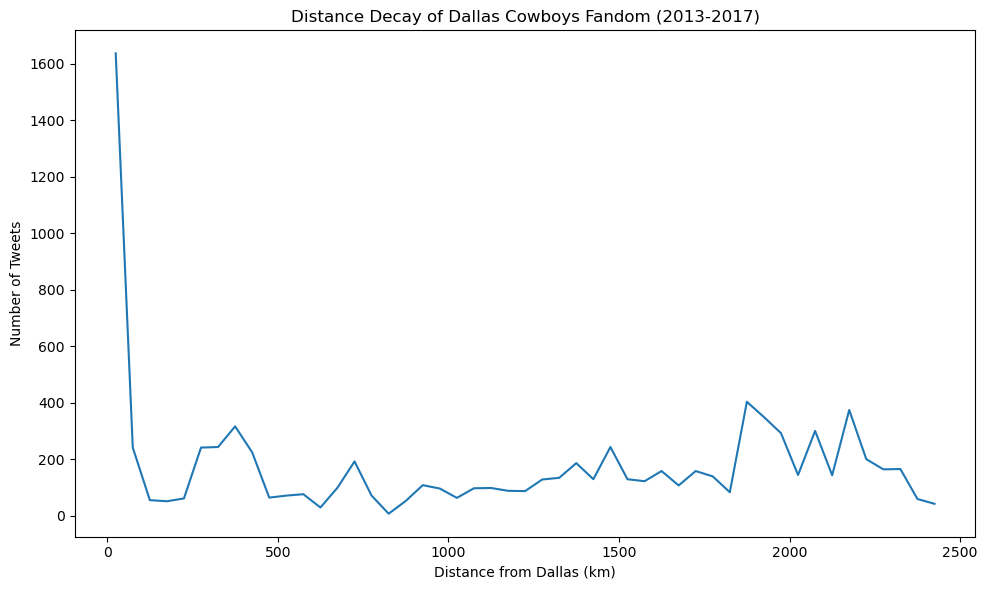

In [26]:
# radius of fandom
dallas_center = Point(-96.7970, 32.7767)

# project tweets to meters
tweets_proj = tweets_with_city.to_crs(epsg=5070)  # NAD83 / Conus Albers

dallas_proj = gpd.GeoSeries(
    [dallas_center],
    crs="EPSG:4326"
).to_crs(epsg=5070).iloc[0]

tweets_proj["distance_km"] = (
    tweets_proj.geometry.distance(dallas_proj) / 1000
)

bins = np.arange(0, 2500, 50)  # 0–2500 km in 50 km bins
tweets_proj["distance_bin"] = pd.cut(
    tweets_proj["distance_km"], bins=bins
)

distance_counts = (
    tweets_proj
    .groupby("distance_bin")
    .size()
    .reset_index(name="tweet_count")
)

# Get bin midpoints for plotting
distance_counts["bin_mid_km"] = (
    distance_counts["distance_bin"]
    .apply(lambda x: x.mid)
    .astype(float)
)


plt.figure(figsize=(10,6))
plt.plot(
    distance_counts["bin_mid_km"],
    distance_counts["tweet_count"]
)
plt.xlabel("Distance from Dallas (km)")
plt.ylabel("Number of Tweets")
plt.title("Distance Decay of Dallas Cowboys Fandom (2013-2017)")
plt.show()



Calculating the average number of tweets in places 1500 km or more from Dallas and then using this as a baseline. Then finding at what distance from Dallas does tweet activity first drop to this background level.

In [27]:
baseline = distance_counts[
    distance_counts["bin_mid_km"] > 1500
]["tweet_count"].mean()

radius_bg = distance_counts[
    distance_counts["tweet_count"] <= baseline
]["bin_mid_km"].iloc[0]

radius_bg

np.float64(125.0)

Plot the fandom radius using the Dallas location

In [30]:

# Dallas location
dallas_lat = 32.7767
dallas_lon = -96.7970
R_km = radius_bg

# Create Dallas point and radius geometry
dallas = gpd.GeoSeries(
    [Point(dallas_lon, dallas_lat)],
    crs="EPSG:4326"
).to_crs(epsg=5070)

circle = dallas.buffer(R_km * 1000).to_crs(epsg=4326)
circle_lon, circle_lat = map(list, circle.iloc[0].exterior.xy)

# Aggregate tweets by metro
metro_summary = (
    tweets_with_city
    .groupby("NAME")
    .agg(
        count=("id", "size"),
        lat=("lat", "mean"),
        lon=("lon", "mean")
    )
    .query("count >= 10")
    .reset_index()
)

# Plot metros, fandom radius, and Dallas
fig = px.scatter_geo(
    metro_summary,
    lat="lat",
    lon="lon",
    size="count",
    hover_name="NAME",
    title="Geographic Radius of Dallas Cowboys Fandom (2013–2017)",
    scope="usa"
)

fig.add_scattergeo(
    lat=circle_lat,
    lon=circle_lon,
    mode="lines",
    line=dict(width=3, dash="dash"),
    name=f"Fandom radius ≈ {int(R_km)} km"
)

fig.add_scattergeo(
    lat=[dallas_lat],
    lon=[dallas_lon],
    mode="markers",
    marker=dict(size=12),
    name="Dallas"
)

fig.update_geos(
    showland=True,
    landcolor="lightgray",
    showocean=True,
    oceancolor="azure"
)

fig.update_layout(
    title_x=0.5,
    title_font_size=20
)

fig.show()


In [31]:
# save as html
fig.write_html("dallas_cowboys_fandom_radius.html")